### LUT M1M3 Improvement Analysis Notebook

Relevant imports

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial import Polynomial
from astropy.time import Time, TimeDelta
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from lsst_efd_client import EfdClient
from lsst.ts.cRIOpy import M1M3FATable
from lsst.sitcom import vandv

Example code of how to plot fields in different EFD topics.

In [2]:
client = EfdClient('summit_efd')

Set start and end time of the sequence that we want to analyze

In [3]:
start = Time('2023-06-24 02:38:0Z', scale='utc')
end = Time('2023-06-24 03:01:0Z', scale='utc')

Create ids vector

In [ ]:
fat = np.array(M1M3FATable.FATABLE, dtype=object)
ids = fat[:, M1M3FATable.FATABLE_ID]

### Retrieve LUT forces from m1m3support file

In [7]:
xForce = [str("".join(("xForces",str(i)))) for i in range(12)]
yForce = [str("".join(("yForces",str(i)))) for i in range(100)]
zForce = [str("".join(("zForces",str(i)))) for i in range(156)]

lut_path = (
    f"{os.environ['HOME']}/notebooks/lsst-ts/ts_m1m3support/"
    "SettingFiles/Tables/"
)

## Get data from EFD

#### Balance forces
We retrieve the force balance data from EFD for z and y forces, that will be added to the LUT. 

In [11]:
df_all_z_forces = await client.select_time_series(
    "lsst.sal.MTM1M3.appliedBalanceForces", 
    zForce, 
    start,
    end
)

df_all_y_forces = await client.select_time_series(
    "lsst.sal.MTM1M3.appliedBalanceForces", 
    yForce, 
    start,
    end
)

# join dataframes and resample them.
df_all_forces = pd.concat([df_all_y_forces.dropna(axis = 1), df_all_z_forces.dropna(axis = 1)])
forces_resampled = df_all_forces.resample('1T').mean()

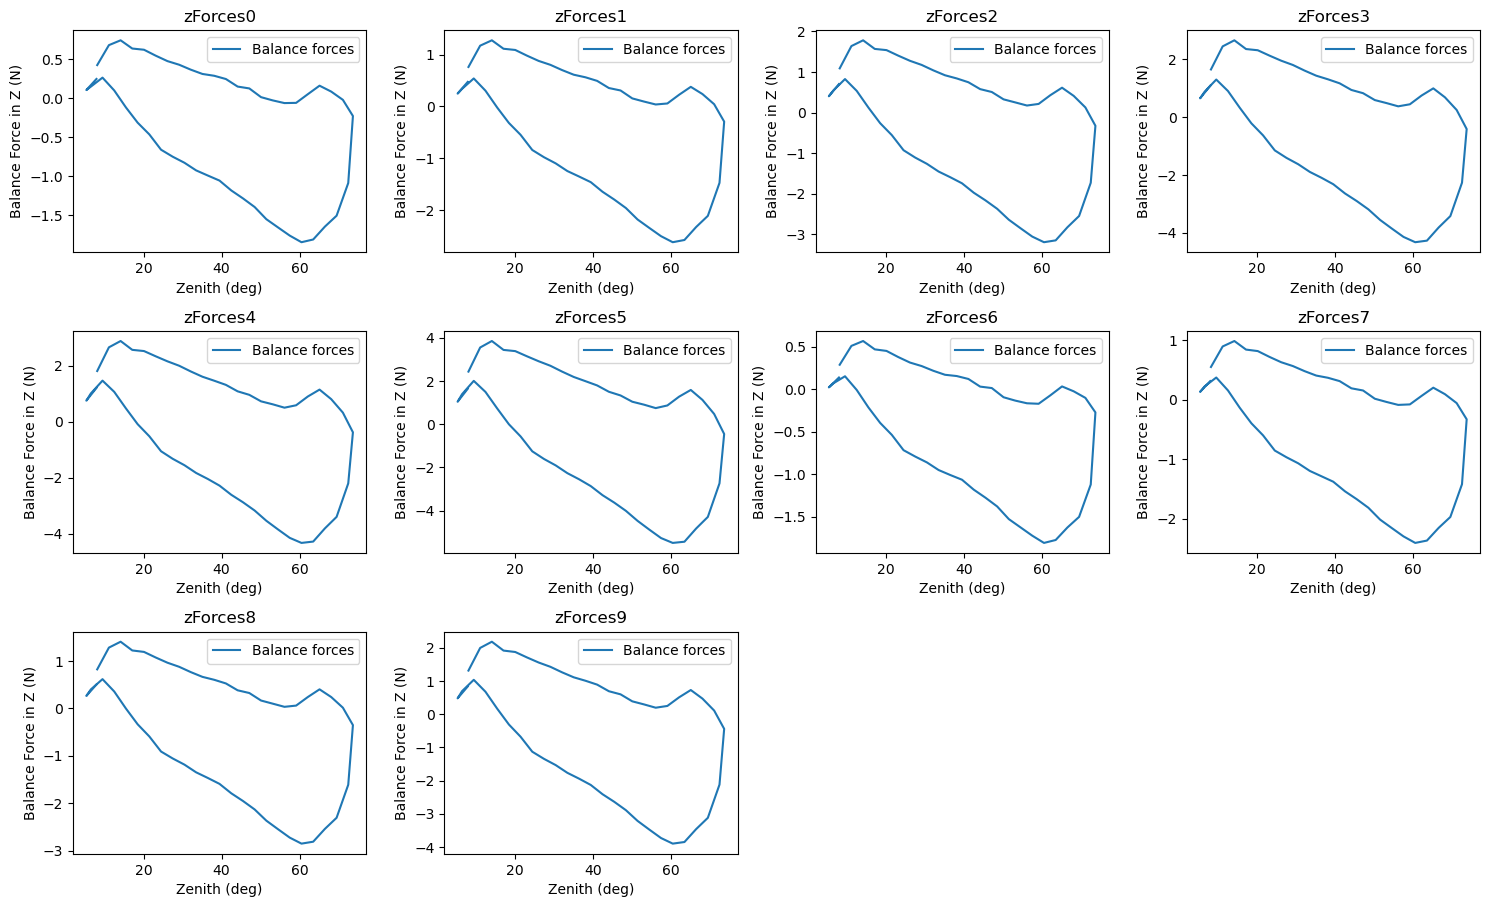

In [14]:
fig = plt.figure(figsize = (15,120))
for idx in range(10):
    plt.subplot(40,4,idx + 1)

    plt.plot(90 - elevations, forces_resampled[zForce[idx]], '-', label = 'Balance forces')
    plt.title(zForce[idx])
    plt.legend()
    plt.ylabel('Balance Force in Z (N)')
    plt.xlabel('Zenith (deg)')
    
plt.tight_layout()

#### Applied forces approach

Retrieve applied forces and static forces. We subtract applied - static = balance + lut in the relevant timeframe

In [ ]:
df_applied_z_forces = await client.select_time_series(
    "lsst.sal.MTM1M3.appliedForces", 
    zForce, 
    start,
    end
)

df_applied_y_forces = await client.select_time_series(
    "lsst.sal.MTM1M3.appliedForces", 
    yForce, 
    start,
    end
)

Retrieve static forces applied

In [ ]:
df_static_z_forces = await client.select_time_series(
    "lsst.sal.MTM1M3.logevent_appliedStaticForces", 
    zForce, 
    start - 1*TimeDelta(1),
    end
)
static_z_forces = df_static_z_forces.iloc[-1]

df_static_y_forces = await client.select_time_series(
    "lsst.sal.MTM1M3.logevent_appliedStaticForces", 
    yForce, 
    start - 1*TimeDelta(1),
    end
)
static_y_forces = df_static_y_forces.iloc[-1]

Subtract applied - static. This is equal to LUT + balance forces, which is what we are interested in fitting.

In [ ]:
for idx in zForce:
    df_applied_z_forces[idx] = df_applied_z_forces[idx].subtract(static_z_forces[idx])
    
for idy in yForce:
    df_applied_y_forces[idy] = df_applied_y_forces[idy].subtract(static_y_forces[idy])
    

Unite dataframes and resample accordingly.

In [ ]:
df_forces_static = pd.concat([df_applied_y_forces, df_applied_z_forces], axis = 1)
forces_static_resampled = df_forces_static.resample('1T').mean()

## Elevation vs time

Look into the elevation plot for which we will perform the analysis.

In [ ]:
# Retrieve elevations
elevations = await client.select_time_series(
    'lsst.sal.MTMount.elevation',
    ['actualPosition', 'timestamp'],  
    start, 
    end,
)  
elevations = elevations['actualPosition'].resample('1T').mean()

elevations.plot()
plt.xlabel('Time (utc)')
plt.ylabel('elevation (deg)')

## Look Up Table for Z forces as a function of elevation

Here we plot in blue the force balance offsets as a function of elevation and on top of it a 5th-order polynomial fit to the data. The coefficients of these polynomial are to be added to the LUT values. The sum of squared residuals of the least squares fit is shown on the top right of the plot.

In [ ]:
lut_fname = "ElevationZTable.csv"
lut_file = os.path.join(lut_path, lut_fname)
table_file = pd.read_csv(lut_file)

table_file

In [ ]:
elevations_lut = np.linspace(0, 90, 90)
lut_zforces = vandv.m1m3.lut_elevation_zforces(elevations_lut, as_array=True)

### Balance forces approach

In [ ]:
lut_fname = "ElevationZTable.csv"
lut_file = os.path.join(lut_path, lut_fname)
table_file = pd.read_csv(lut_file)

axis_indices = fat[:, 11] # set axis indices to update M1M3 LUT file. changes dependening on axis Z = 11, Y = 10, X = 9

fig = plt.figure(figsize = (15,120))
for idx in range(156):
    plt.subplot(40,4,idx + 1)

    new_poly, [residual, _, _, _] = Polynomial.fit(90 - elevations, forces_resampled[zForce[idx]], 5, full=True)
    coefs = np.flip(new_poly.convert().coef)
    
    actuator_id = ids[np.where(axis_indices == idx)[0][0]]

    coefs = np.insert(coefs,0,0)
    table_file.loc[table_file['ID'] == actuator_id] += coefs
    
    plt.plot(90 - elevations, new_poly(90 - elevations), '--.k', label = 'Fit')
    plt.plot(90 - elevations, forces_resampled[zForce[idx]], '-', label = 'Balance forces')
    plt.title(zForce[idx])
    plt.plot([], [], ' ', label=f"err={np.round(residual,4)}")
    plt.legend()
    plt.ylabel('Balance Force in Z (N)')
    plt.xlabel('Zenith (deg)')

table_file.to_csv(f'ElevationZTableBalance.csv', index=False)
plt.tight_layout()


### Applied forces approach

In [ ]:
lut_fname = "ElevationZTable.csv"
lut_file = os.path.join(lut_path, lut_fname)
table_file = pd.read_csv(lut_file)

fig = plt.figure(figsize = (15,120))
for idx in range(156):
    plt.subplot(40,4,idx + 1)
    new_poly, [residual, _, _, _] = Polynomial.fit(90 - elevations, forces_static_resampled[zForce[idx]], 5, full=True)

    coefs = np.flip(new_poly.convert().coef)
    actuator_id = ids[np.where(axis_indices == idx)[0][0]]
    
    coefs = np.insert(coefs,0,actuator_id)
    table_file.loc[table_file['ID'] == actuator_id] = coefs
    
    plt.plot(90 - elevations, new_poly(90 - elevations), '--.k', label = 'fit')
    plt.plot(90 - elevations, forces_static_resampled[zForce[idx]], '-', label = 'LUT + balance')
    plt.title(zForce[idx])
    plt.plot([], [], ' ', label=f"err={np.round(residual,4)}")
    plt.legend()
    plt.ylabel('LUT + Balance in Z (N)')
    plt.xlabel('Zenith (deg)')
    
plt.tight_layout()
table_file.to_csv(f'ElevationZTableApplied.csv', index=False)

Compare both fits. We should get a very similar values for the coefficients. We will show just the first 10 actuators

In [ ]:
lut_fname = "ElevationZTableApplied.csv"
table_applied = pd.read_csv(lut_fname)

lut_fname = "ElevationZTableBalance.csv"
table_balance = pd.read_csv(lut_fname)

table_applied.head(5)
table_balance.head(5)

## Look Up Table for Y forces as a function of elevation

Here we plot in blue the force balance offsets as a function of elevation and on top of it a 5th-order polynomial fit to the data. The coefficients of these polynomial are to be added to the LUT values. The sum of squared residuals of the least squares fit is shown on the top right of the plot.

In [ ]:
lut_fname = "ElevationYTable.csv"
lut_file = os.path.join(lut_path, lut_fname)
table_file = pd.read_csv(lut_file)

table_file

In [ ]:
lut_fname = "ElevationYTable.csv"
lut_file = os.path.join(lut_path, lut_fname)
table_file = pd.read_csv(lut_file)

axis_indices = fat[:, 10] # set axis indices to update M1M3 LUT file. changes dependening on axis Z = 11, Y = 10, X = 9

fig = plt.figure(figsize = (15,75))
for idx in range(100):
    plt.subplot(25,4,idx + 1)

    new_poly, [residual, _, _, _] = Polynomial.fit(90 - elevations, forces_resampled[yForce[idx]], 5, full=True)

    coefs = np.flip(new_poly.convert().coef)
    actuator_id = ids[np.where(axis_indices == idx)[0][0]]
    
    coefs = np.insert(coefs,0,0)
    table_file.loc[table_file['ID'] == actuator_id] += coefs

    plt.plot(90 - elevations, forces_resampled[yForce[idx]], '-', label = 'Balance forces')
    plt.plot(90 - elevations, new_poly(90 - elevations), '--.k', label = 'Fit')
    plt.title(yForce[idx])
    plt.plot([], [], ' ', label=f"err={np.round(residual,4)}")
    plt.legend()
    plt.ylabel('Balance Force in Y (N)')
    plt.xlabel('Zenith (deg)')

plt.tight_layout()
table_file.to_csv(f'ElevationYTableBalance.csv', index=False)

### Applied approach

Fit Applied forces - static forces

In [ ]:
lut_fname = "ElevationYTable.csv"
lut_file = os.path.join(lut_path, lut_fname)
table_file = pd.read_csv(lut_file)

axis_indices = fat[:, 10] # set axis indices to update M1M3 LUT file. changes dependening on axis Z = 11, Y = 10, X = 9

fig = plt.figure(figsize = (15,75))
for idx in range(100):
    plt.subplot(25,4,idx + 1)
    new_poly, [residual, _, _, _] = Polynomial.fit(90 - elevations, forces_static_resampled[yForce[idx]], 5, full=True)

    coefs = np.flip(new_poly.convert().coef)
    actuator_id = ids[np.where(axis_indices == idx)[0][0]]
    
    coefs = np.insert(coefs,0,actuator_id)
    table_file.loc[table_file['ID'] == actuator_id] = coefs
    
    plt.plot(90 - elevations, new_poly(90 - elevations), '--.k', label = 'fit')
    plt.plot(90 - elevations, forces_static_resampled[yForce[idx]], '-', label = 'LUT + balance')
    plt.title(yForce[idx])
    plt.plot([], [], ' ', label=f"err={np.round(residual,4)}")
    plt.legend()
    plt.ylabel('LUT + Balance in Y (N)')
    plt.xlabel('Zenith (deg)')
    
plt.tight_layout()
table_file.to_csv('ElevationYTableApplied.csv', index=False)